# Imports & Config

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import skew

# Load the dataset
df = pd.read_csv('weatherAUS.csv')

# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# Data Cleaning
- Parse Date and extract features (Year, Month, Day).
- Map 'RainToday' and 'RainTomorrow' to binary (handle later in pipeline for consistency).
- Drop rows where target 'RainTomorrow' is NaN.
- Check and remove duplicates if any.
- Handle 'NA' strings (but in this CSV, missing are NaN already).

In [18]:
# Parse Date
df['Date'] = pd.to_datetime(df['Date'])

# Feature Engineering: Extract Year, Month, Day (for seasonality)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Drop original Date
df.drop('Date', axis=1, inplace=True)

# Drop rows with missing target
df = df.dropna(subset=['RainTomorrow'])

# Check duplicates
print(f"Number of duplicates: {df.duplicated().sum()}")
# Remove if any
df = df.drop_duplicates()

# Map target to binary
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

# Identify columns
num_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
            'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
            'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day']
cat_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

# Handle RainToday mapping in pipeline, but for EDA, temp map
df_eda = df.copy()
df_eda['RainToday'] = df_eda['RainToday'].map({'Yes': 1, 'No': 0})

Number of duplicates: 0


# Handling Outliers and Skewness

- Detect outliers using IQR method and cap them (to avoid removal and lose data).
- Check skewness and apply log1p transformation to highly skewed features (>1 or <-1).

In [19]:
# Function to cap outliers using IQR
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return np.clip(series, lower, upper)

# Apply to numerical columns (before imputation for simplicity, but ideally after)
for col in num_cols[:-3]:  # Exclude date features
    if col in df.columns:
        df[col] = cap_outliers(df[col])

# Check skewness
skewness = df[num_cols].apply(lambda x: skew(x.dropna()))
print("Skewness:\n", skewness)

# Apply log1p to highly skewed columns (e.g., Rainfall)
skewed_cols = skewness[abs(skewness) > 1].index
for col in skewed_cols:
    if col in df.columns:
        df[col] = np.log1p(df[col])

print("Skewness after transformation:\n", df[num_cols].apply(lambda x: skew(x.dropna())))

Skewness:
 MinTemp          0.024580
MaxTemp          0.238974
Rainfall         1.239891
Evaporation      0.809028
Sunshine        -0.502901
WindGustSpeed    0.558902
WindSpeed9am     0.505132
WindSpeed3pm     0.397973
Humidity9am     -0.431715
Humidity3pm      0.034515
Pressure9am     -0.016928
Pressure3pm      0.012846
Cloud9am        -0.224282
Cloud3pm        -0.224088
Temp9am          0.095453
Temp3pm          0.253632
Year            -0.042628
Month            0.028958
Day              0.008762
dtype: float64
Skewness after transformation:
 MinTemp          0.024580
MaxTemp          0.238974
Rainfall         1.122694
Evaporation      0.809028
Sunshine        -0.502901
WindGustSpeed    0.558902
WindSpeed9am     0.505132
WindSpeed3pm     0.397973
Humidity9am     -0.431715
Humidity3pm      0.034515
Pressure9am     -0.016928
Pressure3pm      0.012846
Cloud9am        -0.224282
Cloud3pm        -0.224088
Temp9am          0.095453
Temp3pm          0.253632
Year            -0.042628
Month 

# Visualization

- Class distribution.
- Correlation matrix for numerical features.
- Boxplots for outliers (post-capping).
- Histograms for distributions.

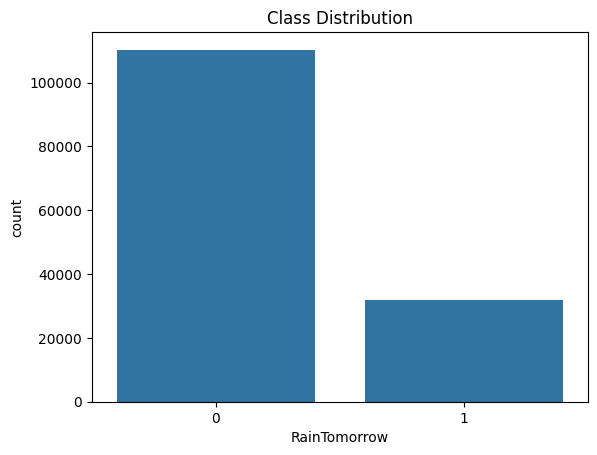

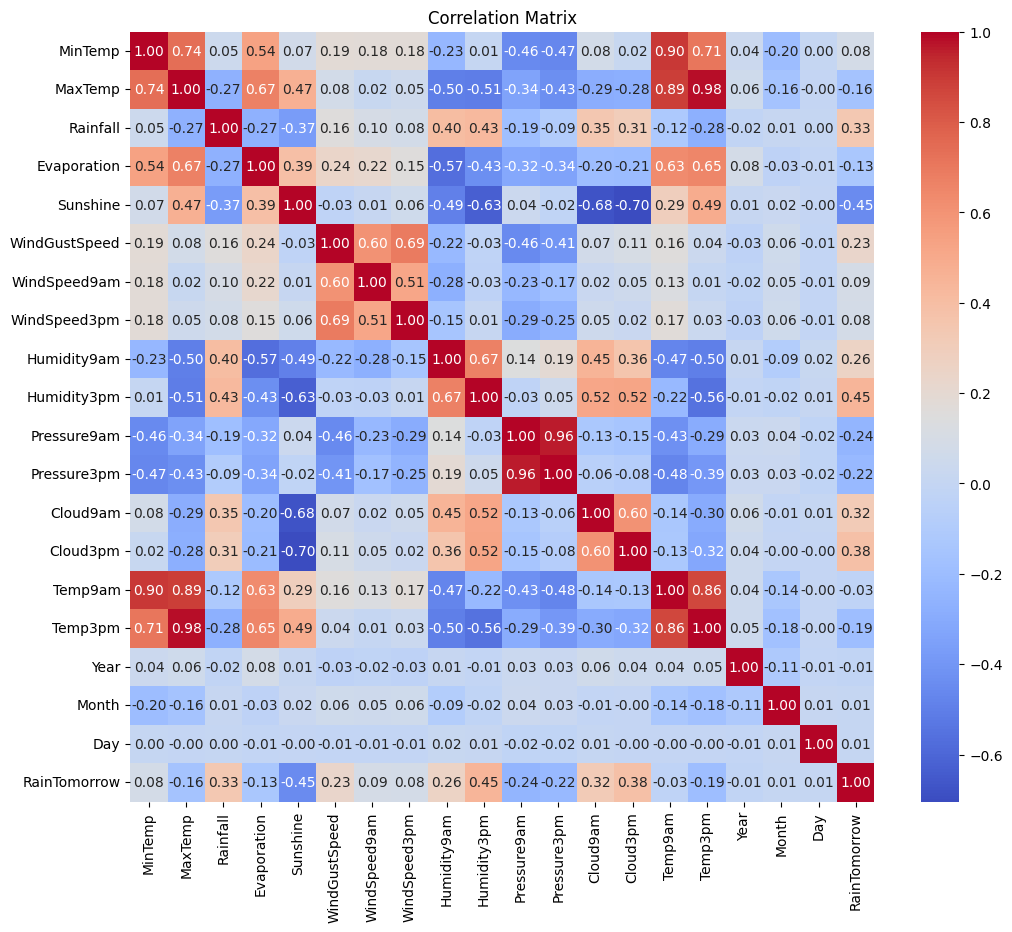

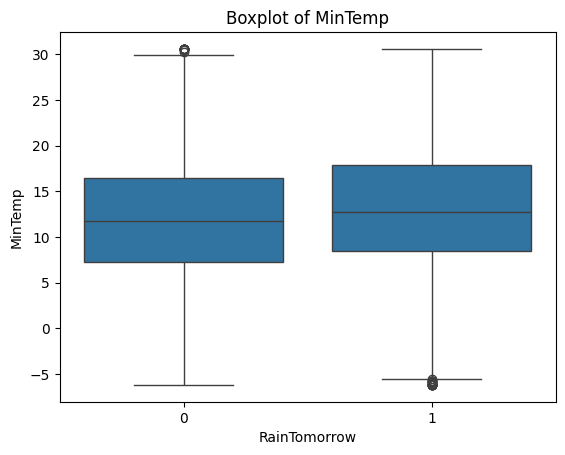

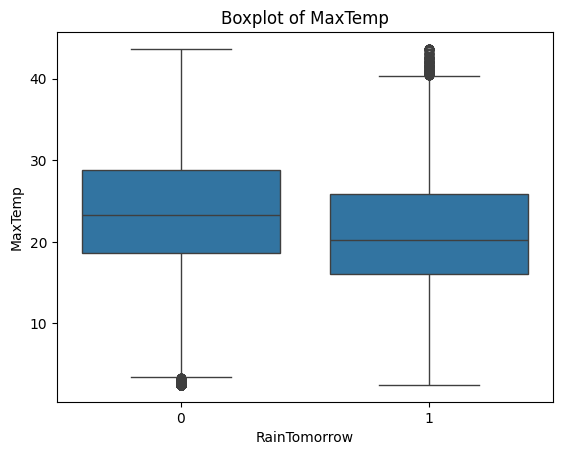

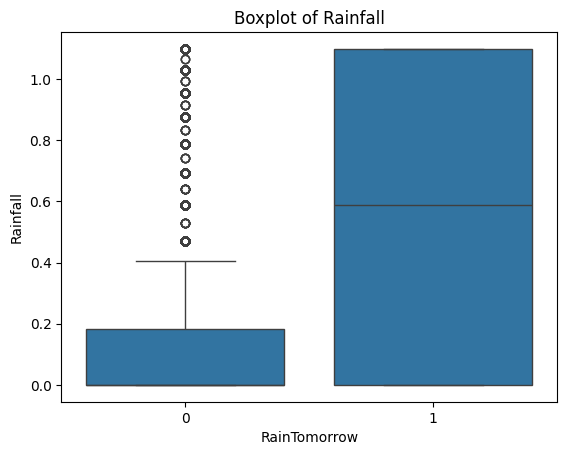

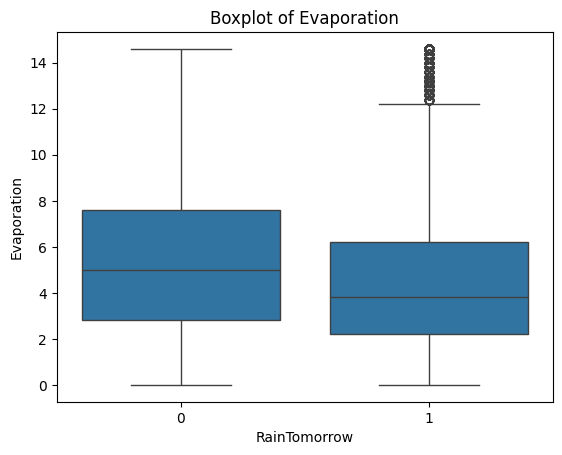

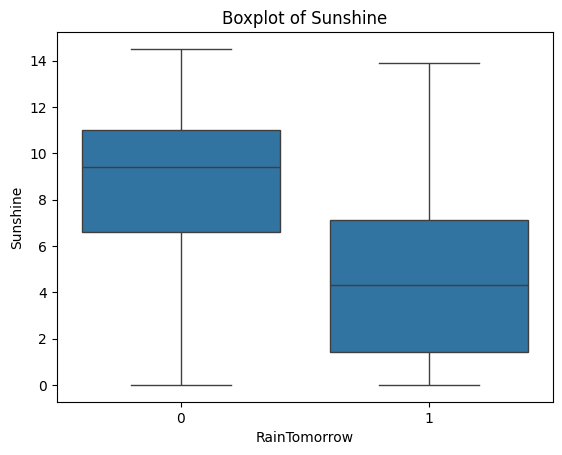

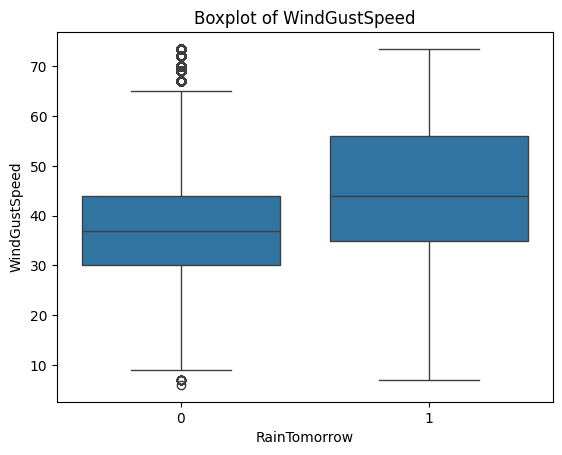

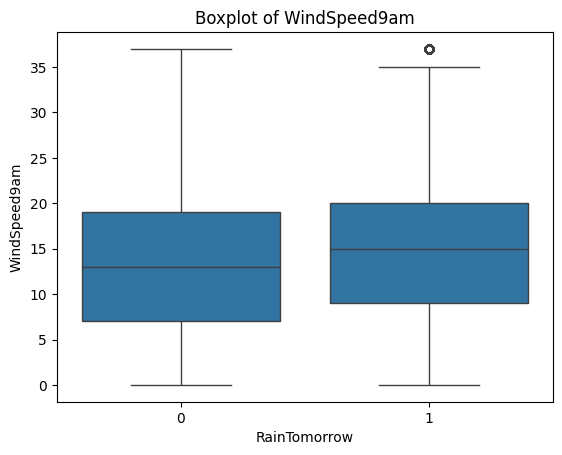

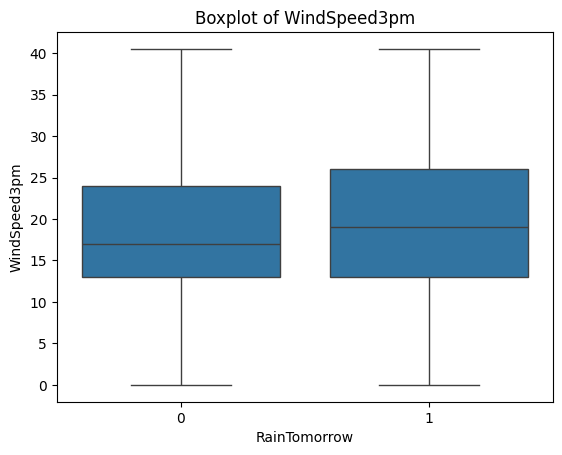

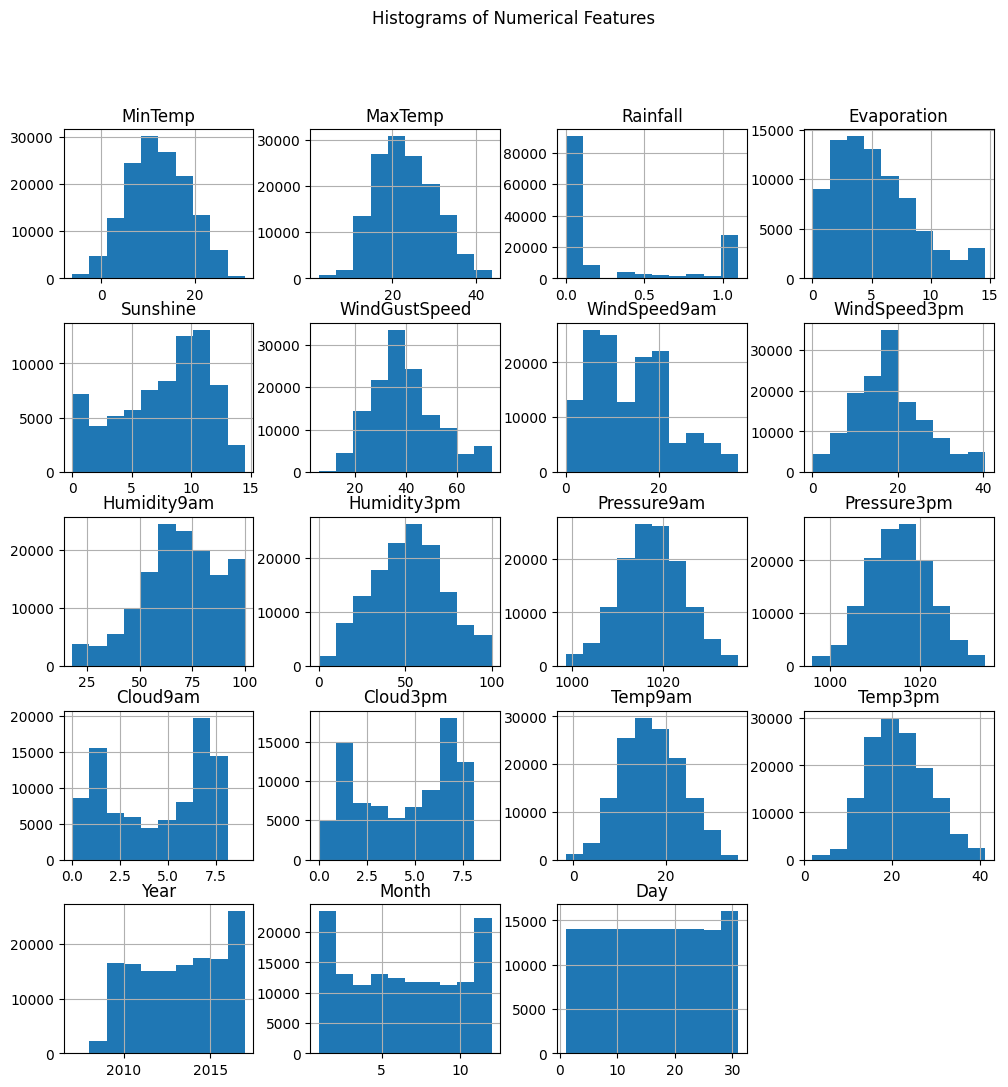

In [20]:
# Class distribution
sns.countplot(x='RainTomorrow', data=df)
plt.title('Class Distribution')
plt.show()

# Correlation matrix
corr = df[num_cols + ['RainTomorrow']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Boxplots for numerical features
for col in num_cols[:8]:  # Sample
    sns.boxplot(x='RainTomorrow', y=col, data=df)
    plt.title(f'Boxplot of {col}')
    plt.show()

# Histograms
df[num_cols].hist(figsize=(12, 12))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Split Data

In [21]:
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing Pipeline
- Impute and scale numerical.
- Impute and one-hot encode categorical (including RainToday as categorical for now).
- Note: RainToday treated as cat to handle NaN.

In [22]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ])

# Dimensionality Reduction with PCA

- Fit preprocessor on train, apply PCA, visualize explained variance.
- Choose n_components for 95% variance.

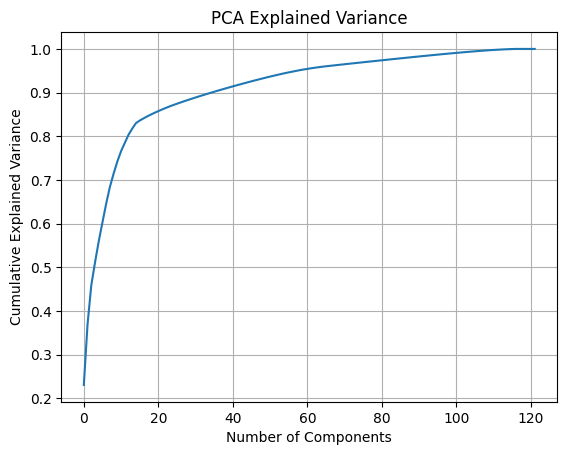

Number of components for 95% variance: 59


In [23]:
# Fit preprocessor on train
X_train_pre = preprocessor.fit_transform(X_train)

# PCA
pca = PCA()
pca.fit(X_train_pre)

# Plot cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Find n for 95% variance
n_components = np.argmax(cum_var >= 0.95) + 1
print(f'Number of components for 95% variance: {n_components}')

# Mutual Information (for feature importance insight)

- Compute on preprocessed train data.

                Feature  MI Score
9      num__Humidity3pm  0.112084
119   cat__RainToday_No  0.060641
4         num__Sunshine  0.056608
2         num__Rainfall  0.055260
13        num__Cloud3pm  0.050719
120  cat__RainToday_Yes  0.042921
8      num__Humidity9am  0.036680
12        num__Cloud9am  0.036331
10     num__Pressure9am  0.028253
11     num__Pressure3pm  0.025538
5    num__WindGustSpeed  0.024904
15         num__Temp3pm  0.021402
1          num__MaxTemp  0.012946
6     num__WindSpeed9am  0.007239
0          num__MinTemp  0.006308
3      num__Evaporation  0.004791
7     num__WindSpeed3pm  0.004513
85    cat__WindDir9am_E  0.003968
88    cat__WindDir9am_N  0.003536
76   cat__WindGustDir_S  0.003123


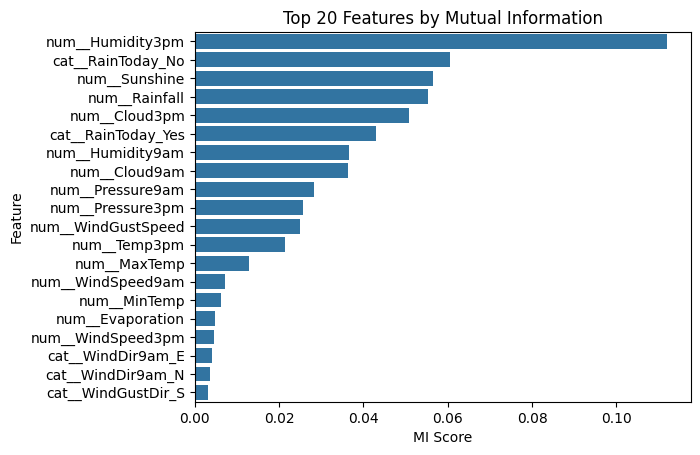

In [24]:
# Mutual Information
mi_scores = mutual_info_classif(X_train_pre, y_train)
mi_df = pd.DataFrame({'Feature': preprocessor.get_feature_names_out(), 'MI Score': mi_scores})
mi_df = mi_df.sort_values('MI Score', ascending=False)
print(mi_df.head(20))  # Top 20

# Visualize top MI
sns.barplot(x='MI Score', y='Feature', data=mi_df.head(20))
plt.title('Top 20 Features by Mutual Information')
plt.show()

# Model Building with Pipeline, Balancing, and Ensemble

- Use ImbPipeline: preprocess -> PCA -> SMOTE -> model.
- Models: RandomForest, LogisticRegression, Voting ensemble.
- GridSearch for RF hyperparameters.

In [25]:
# Define model pipeline
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),  # Retain 95% variance
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Grid Search for RF
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_}")

# Best model
best_model = grid_search.best_estimator_

# Ensemble: Add LR and Voting
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

rf = best_model.named_steps['classifier']
lr = lr_pipeline.fit(X_train, y_train).named_steps['classifier']

# For voting, need to apply preprocess and PCA first
# Predict on test using best RF for now, then ensemble if better

# For simplicity, use RF as main, try voting separately if time

Best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best CV accuracy: 0.8342300345691844


# Evaluation

Accuracy: 0.8382
F1 Score: 0.6476
Recall: 0.6634
Precision: 0.6326
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     22064
           1       0.63      0.66      0.65      6375

    accuracy                           0.84     28439
   macro avg       0.77      0.78      0.77     28439
weighted avg       0.84      0.84      0.84     28439



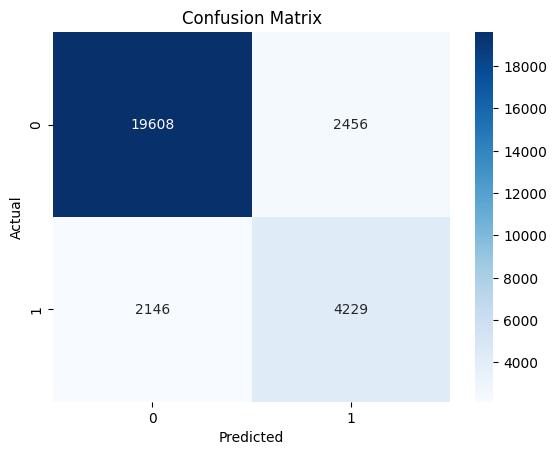

In [26]:
# Predict on test
X_test_pre = best_model.named_steps['preprocessor'].transform(X_test)
X_test_pca = best_model.named_steps['pca'].transform(X_test_pre)  # SMOTE not applied to test
y_pred = best_model.named_steps['classifier'].predict(X_test_pca)  # But since pipeline fitted with SMOTE on train

# Wait, better: since pipeline has SMOTE, but predict doesn't apply SMOTE, it's fine.
y_pred = best_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()